# Feature Extractor

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import cv2
import torch
from sklearn.metrics import accuracy_score,log_loss
from tensorflow import keras

In [ ]:
vgg_16 = keras.applications.VGG16(include_top=False,weights='imagenet',input_shape=(800,800,3))

In [ ]:
vgg_16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 800, 800, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 800, 800, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 800, 800, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 400, 400, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 400, 400, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 400, 400, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 200, 200, 128)     0     

In [ ]:
fe = keras.Sequential()

In [ ]:
for layer in vgg_16.layers[:-1] :
  fe.add(layer)

In [ ]:
for layer in fe.layers :
  layer.trainable = False

In [ ]:
fe.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 800, 800, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 800, 800, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 400, 400, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 400, 400, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 400, 400, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 200, 200, 128)     0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 200, 200, 256)     2

In [ ]:
fe.output_shape

(None, 50, 50, 512)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Anchor Boxes

In [ ]:
annotion_path='/content/drive/My Drive/Attrition/annotion_1'
image_path='/content/drive/My Drive/Attrition/image_1'

In [ ]:
ratios=[0.5,1,2]
anchor_scales=[8,16,32]
sub_sample =16

In [ ]:
img = cv2.imread(os.path.join(image_path,'0.jpg'))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
h_ratio,w_ratio=800/img.shape[0],800/img.shape[1]
img = cv2.resize(img,(800,800))
annotions=open(os.path.join(annotion_path,'0.txt'))
file=annotions.readlines()
gt_box=[]
for i in range(len(file)):
  split=file[i].split(' ')
  x=[float(i) for i in split[:4]]
  y=[float(i) for i in split[4:-1]]
  x1,x2,y1,y2=round(min(x)*w_ratio),round(max(x)*w_ratio),round(min(y)*h_ratio),round(max(y)*h_ratio)
  gt_box.append([x1,y1,x2,y2])

In [ ]:
gt_label=np.ones(len(gt_box))

In [ ]:
print(gt_box)

[[20, 155, 123, 257], [260, 527, 461, 733], [675, 76, 773, 242], [354, 239, 416, 309], [41, 323, 220, 490], [45, 629, 247, 778], [-3, 245, 71, 313], [458, 236, 684, 345], [450, 428, 674, 521], [635, 8, 740, 152]]


In [ ]:
img = np.expand_dims(img,0)
extracted_feature=fe(img)

In [ ]:
extracted_feature=np.array(extracted_feature)
extracted_feature=extracted_feature.reshape(1,512,50,50)
extracted_feature.shape

(1, 512, 50, 50)

In [ ]:
def create_anchors():  
  # Anchor boxes for all the pixels
  fe_size = 800//16
  ctr_x = np.arange(16,(fe_size+1)*16,16)
  ctr_y = np.arange(16,(fe_size+1)*16,16)

  # generating centres 
  ctr = np.zeros(((fe_size*fe_size),2))
  index = 0
  for x in range(len(ctr_x)) :
    for y in range(len(ctr_y)) :
      ctr[index,0] = ctr_x[x]-8
      ctr[index,1] = ctr_y[y]-8
      index+=1

  # generating anchors at each centre
  anchors = np.zeros(((fe_size*fe_size*9),4),dtype=np.float32)
  index = 0
  for c in ctr :
    ctr_x,ctr_y = c
    for i in range(len(ratios)) :
      for j in range(len(anchor_scales)) :
        h = sub_sample * anchor_scales[j] * np.sqrt(ratios[i])
        w = sub_sample * anchor_scales[j] * np.sqrt(1./ ratios[i])

        anchors[index, 0] = ctr_y - h / 2.
        anchors[index, 1] = ctr_x - w / 2.
        anchors[index, 2] = ctr_y + h / 2.
        anchors[index, 3] = ctr_x + w / 2.
        index += 1
  return anchors
anchors=create_anchors()        
print(anchors.shape)

(22500, 4)


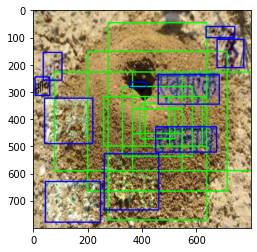

In [ ]:
img = cv2.imread(os.path.join(image_path,'0.jpg'))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(800,800))
img0=img.copy()
for i in range(11500,11510):
  cv2.rectangle(img0,(round(anchors[i,0]),round(anchors[i,1])),(round(anchors[i,2]),round(anchors[i,3])),(0,255,0),3)

for i in range(len(gt_box)):
  cv2.rectangle(img0,(gt_box[i][0],gt_box[i][1]),(gt_box[i][2],gt_box[i][3]),(0,0,255),3)
plt.imshow(img0)
plt.show()

In [ ]:
# filtering the valid anchors
index_inside = np.where(
    (anchors[:,0] >= 0) &
    (anchors[:,1] >= 0) &
    (anchors[:,2] <= 800) &
    (anchors[:,3] <= 800)
)[0]
print(index_inside.shape)

# valid anchor boxes 
valid_anchor_boxes = anchors[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


In [ ]:
len(valid_anchor_boxes)

8940

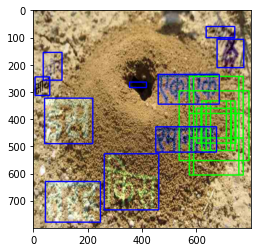

In [ ]:
img0=img.copy()
for i in range(5000,5010):
  cv2.rectangle(img0,(round(valid_anchor_boxes[i,0]),round(valid_anchor_boxes[i,1])),(round(valid_anchor_boxes[i,2]),round(valid_anchor_boxes[i,3])),(0,255,0),3)

for i in range(len(gt_box)):
  cv2.rectangle(img0,(gt_box[i][0],gt_box[i][1]),(gt_box[i][2],gt_box[i][3]),(0,0,255),3)
plt.imshow(img0)
plt.show()

In [ ]:
# function to calculate iou
def i_o_u(box1,box2) :
  box1_x1,box1_y1,box1_x2,box1_y2 = box1[0],box1[1],box1[2],box1[3]
  box2_x1,box2_y1,box2_x2,box2_y2 = box2[0],box2[1],box2[2],box2[3]
  x1 = max(box1_x1,box2_x1)
  y1 = max(box1_y1,box2_y1)
  x2 = min(box1_x2,box2_x2)
  y2 = min(box1_y2,box2_y2)

  w = max(x2-x1,0)
  h = max(y2-y1,0)

  inter_area = w*h
  union_area = (box1_x2-box1_x1)*(box1_y2-box1_y1) + (box2_x2-box2_x1)*(box2_y2-box2_y1) - inter_area

  iou = inter_area/union_area
  return iou

In [ ]:
# checking iou function
print(i_o_u([1,1,3,3],[2,2,4,4])) # should be 0.1428
print(i_o_u([1,1,3,3],[2,3,4,4])) # should be zero
print(i_o_u([1,1,3,3],[4,4,6,6])) # should be zero

0.14285714285714285
0.0
0.0


In [ ]:
# ious of valid_anchor boxes and ground truth
def generate_ious(valid_anchor_boxes,gt_boxes):
  ious = np.empty((len(valid_anchor_boxes),len(gt_boxes)))
  for i in range(len(valid_anchor_boxes)):
    for j in range(len(gt_boxes)) :
      ious[i][j] = i_o_u(valid_anchor_boxes[i],gt_boxes[j])
  return ious

In [ ]:
ious_check = generate_ious(valid_anchor_boxes,gt_box)

In [ ]:
ious_check.shape

(8940, 10)

In [ ]:
a=np.max(ious_check,axis=1)
print(len(np.where(a>0.45)[0]))#no positive samples

0


In [ ]:
# checking ious function
val_anchor_boxes = [[1,1,3,3],[2,2,3,3]]
gt_boxes = [[2,2,4,4],[2,3,4,4],[4,4,6,6]]

ious = generate_ious(val_anchor_boxes,gt_boxes)
print(ious.shape)
print(ious)

(2, 3)
[[0.14285714 0.         0.        ]
 [0.25       0.         0.        ]]


In [ ]:
len(val_anchor_boxes)

2

Considering the scenarios of a and b, we need to find two things here :
a.the highest iou for each gt_box and its corresponding anchor box
b.the highest iou for each anchor box and its corresponding ground truth box

In [ ]:
# label anchor boxes 
def label_anchor_boxes(valid_anchor_boxes,ground_truth,pos_threshold,neg_threshold) :
  #gnerating labels
  ious = generate_ious(valid_anchor_boxes,ground_truth)
  max_iou_gt = np.max(ious,axis=0)
  label = np.empty(len(valid_anchor_boxes),dtype=np.int32)
  label.fill(-1) 
  ious_max = np.max(ious,axis=1)
  gt_index = np.argmax(ious,axis=1)
  for i in range(len(valid_anchor_boxes)) :
    if ious_max[i] >= pos_threshold :
      label[i] = 1
    elif ious_max[i] <= neg_threshold :
      label[i] = 0
  return label,gt_index  

In [ ]:
#valid_anchor_boxes are the original valid anchors
#gt_box is the example taken
check_label,check_indices = label_anchor_boxes(valid_anchor_boxes,gt_box,0.45,0.3)
print(check_label.shape)
print(check_indices.shape)

(8940,)
(8940,)


In [ ]:
print(len(np.where(check_label==1)[0]))

0


In [ ]:
pos_ratio = 0.5
n_sample = 256
n_pos = pos_ratio*n_sample

In [ ]:
def get_neg_pos_samples(labels) :
  pos_index = np.where(labels==1)[0]
  if len(pos_index) > n_pos :
    disable_index = np.random.choice(pos_index,size=int((len(pos_index)-n_pos)),replace=False)
    labels[disable_index] = -1
  n_neg = n_sample * np.sum(labels == 1)
  neg_index = np.where(labels == 0)[0]
  if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
    labels[disable_index] = -1
  return labels

In [ ]:
labels_check = get_neg_pos_samples(check_label)
print(len(np.where(labels_check==1)[0]))

0


In [ ]:
# assign the locations to each anchor box with the ground truth object which has maximum iou
#we need to find the locations of ground truth with respect to the anchor box location
def corner_to_ctr(arr) :
  x1,y1,x2,y2 = arr[0],arr[1],arr[2],arr[3]
  x = (x2+x1)/2
  y = (y2+y1)/2
  w = np.abs((x2-x1))
  h = np.abs((y2-y1))
  return np.array([x,y,w,h],dtype=np.float32)

corner_to_ctr([2,2,4,4])

array([3., 3., 2., 2.], dtype=float32)

In [ ]:
# location of an anchor box w.r.t. given ground truth box
def calc_loc(anchor_box,gt_box):
  x,y,w,h = gt_box[0],gt_box[1],gt_box[2],gt_box[3]
  x_a,y_a,w_a,h_a = anchor_box[0],anchor_box[1],anchor_box[2],anchor_box[3]
  loc_box = np.empty((4,),dtype=np.float32)
  loc_box[0] = (x-x_a)/w_a
  loc_box[1] = (y-y_a)/h_a
  loc_box[2] = np.log(w/w_a)
  loc_box[3] = np.log(h/h_a)
  return loc_box
calc_loc([1,1,2,2],[1,1,2,3])

array([0.       , 0.       , 0.       , 0.4054651], dtype=float32)

In [ ]:
# generating locations for all anchor boxes
def gen_locs(valid_anchor_boxes,gt_boxes,pos_threshold,neg_threshold,index_inside):
  label,indices = label_anchor_boxes(valid_anchor_boxes,gt_boxes,pos_threshold,neg_threshold)
  anchor_locs = np.empty(shape=valid_anchor_boxes.shape,dtype=np.float32)
  for i in range(len(label)) :
    anchor_box = corner_to_ctr(valid_anchor_boxes[i])
    gt_box = corner_to_ctr(gt_boxes[indices[i]])
    anchor_locs[i] = calc_loc(anchor_box,gt_box)
    
  anchor_locations = np.empty((22500,4),dtype=np.float32)
  anchor_locations.fill(0)
  anchor_labels = np.empty((22500,),dtype=np.int8)
  anchor_labels.fill(-1)
  anchor_labels[index_inside] = label
  anchor_locations[index_inside] = anchor_locs
  return anchor_locations,anchor_labels

In [ ]:
anchor_locations_check, anchor_labels_check = gen_locs(valid_anchor_boxes,gt_box,0.45,0.3,index_inside)
print(anchor_locations_check.shape)
print(anchor_labels_check.shape)

(22500, 4)
(22500,)


In [ ]:
print(anchor_locations_check[index_inside][6])

[-0.70986885  1.6572814  -0.96449745  0.11951605]


In [ ]:
(anchor_labels_check[index_inside] == 1).sum()

0

# Region Proposal Network

In [ ]:
def RPN(fe_layer,n_anchors):
  x = keras.layers.Conv2D(512,(3,3),padding='same',activation='relu',
                          kernel_initializer='normal', name='rpn_conv1')(fe_layer)
  x_class = keras.layers.Conv2D(n_anchors,(1,1),activation='sigmoid',
                                kernel_initializer='uniform', name='rpn_cls')(x)
  x_reg = keras.layers.Conv2D(n_anchors*4,(1,1),activation='linear',
                                kernel_initializer='zero', name='rpn_reg')(x)
  return [x_class,x_reg,fe_layer]

# Making a model class

In [ ]:
def base_model(sequential_model,input_tensor=None) :
  input_shape = (800,800,3)
  if input_tensor is None :
    img_input = keras.Input(shape=input_shape)
  else:
    img_input = input_tensor
  out = sequential_model(img_input)
  return out

In [ ]:
img_input=keras.Input(shape=(800,800,3))
layer_in=base_model(fe,img_input)
rpn_layer=RPN(layer_in,9)
model=keras.models.Model(inputs=img_input,outputs=rpn_layer[:2])

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 800, 800, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 50, 50, 512)  14714688    input_18[0][0]                   
__________________________________________________________________________________________________
rpn_conv1 (Conv2D)              (None, 50, 50, 512)  2359808     sequential[7][0]                 
__________________________________________________________________________________________________
rpn_cls (Conv2D)                (None, 50, 50, 9)    4617        rpn_conv1[0][0]                  
____________________________________________________________________________________________

In [ ]:
cls,reg = model(img)

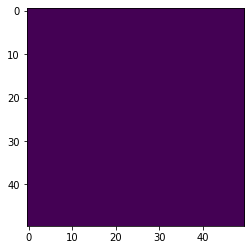

In [ ]:
plt.imshow(reg[0,:,:,35])

In [ ]:
cls_p = cls.numpy().reshape((22500,1))
reg_p = reg.numpy().reshape((22500,4))

In [ ]:
print(cls_p.shape,reg_p.shape)

(22500, 1) (22500, 4)


In [ ]:
print(cls_p[:3,:],reg_p[:3,:])

[[2.3001432e-04]
 [2.6828647e-03]
 [9.9978042e-01]] [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


#Generating proposals

In [ ]:
def generate_proposals(mode,nms_thresh,n_train_pre_nms,n_train_post_nms,n_test_ore_nms,
                       n_test_post_nms,min_size,anchors,cls_p,reg_p) :
  if mode == 'train' :
    n_pre_nms = n_train_pre_nms
    n_post_nms = n_train_post_nms
  elif mode == 'test' :
    n_pre_nms = n_test_pre_nms
    n_post_nms = n_test_post_nms
  # converting anchers to x,y,h,w format
  x_a = (anchors[:,0] + anchors[:,2])/2
  y_a = (anchors[:,1] + anchors[:,3])/2
  h_a = anchors[:,3] - anchors[:,1]
  w_a = anchors[:,2] - anchors[:,0]
  # getting x,y,h,w from predicted locations
  x = (w_a * reg_p[:,0]) + x_a
  y = (h_a * reg_p[:,1]) + y_a
  w = np.exp(reg_p[:,2]) * w_a
  h = np.exp(reg_p[:,3]) * h_a
  #region of interest
  roi = np.zeros(shape=(22500,4),dtype=np.float32)

  roi[:,0] = x - w/2
  roi[:,1] = y - h/2
  roi[:,2] = x + w/2
  roi[:,3] = y + h/2

  roi_clipped=np.clip(roi,0,800)
  scores = cls_p
  order = scores.ravel().argsort()[::-1]
  order = order[:n_pre_nms]
  scores =scores[order]
  roi = roi_clipped[order, :] # valid rois pre nms
  
  # applying nms
  order= scores.ravel().argsort()[::-1]

  x1 = roi[:,0]
  y1 = roi[:,1]
  x2 = roi[:,2]
  y2 = roi[:,3]
  
  areas = (x2-x1)*(y2-y1)
  keep = []
  
  while order.size > 0 :
    i = order[0]
    keep.append(i)
    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 )
    h = np.maximum(0.0, yy2 - yy1 )
    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]
  
  keep = keep[:n_post_nms]
  roi = roi[keep]
  
  return roi

In [ ]:
roi = generate_proposals('train',0.7,12000,2000,6000,300,16,anchors,cls_p,reg_p)

In [ ]:
roi.shape

(2000, 4)

# proposal targets

In [ ]:
def gen_proposal_targets(roi,gt_boxes,gt_label,n_sample,pos_ratio,pos_iou_thresh,neg_iou_thresh):
  ious = generate_ious(roi,gt_box)
  gt_argmax_roi = np.argmax(ious,axis=1)
  max_iou = np.max(ious,axis=1)
  gt_roi_label = np.ones((ious.shape[0]))
  
  # positive roi samples
  pos_roi_per_image = n_sample*pos_ratio
  pos_index = np.where(max_iou >= pos_iou_thresh)[0]
  pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
  if pos_index.size > 0:
    pos_index = np.random.choice(
        pos_index, size=pos_roi_per_this_image, replace=False)
  
  # negative roi samples
  neg_index = np.where((max_iou < neg_iou_thresh) &
                             (max_iou >=0))[0]
  neg_roi_per_this_image = n_sample - pos_roi_per_this_image
  neg_roi_per_this_image = int(min(neg_roi_per_this_image,
                                 neg_index.size))
  if  neg_index.size > 0 :
    neg_index = np.random.choice(
        neg_index, size=neg_roi_per_this_image, replace=False)

  # generating the sample roi
  keep_index = np.append(pos_index, neg_index)
  gt_roi_labels = gt_roi_label[keep_index]
  gt_roi_labels[pos_roi_per_this_image:] = 0 # negative labels --> 0
  sample_roi = roi[keep_index]

  desired_gt_box=gt_argmax_roi[keep_index]
  gt_box_for_sampled_roi = np.zeros((keep_index.shape[0],4))
  for i in range(keep_index.shape[0]):
    for j in range(4):
      gt_box_for_sampled_roi[i][j]=gt_box[desired_gt_box[i]][j]  

  
  # getting the locations rois
  x_a = (sample_roi[:,0] + sample_roi[:,2])/2
  y_a = (sample_roi[:,1] + sample_roi[:,3])/2
  w_a = np.abs(sample_roi[:,2] - sample_roi[:,0])
  h_a = np.abs(sample_roi[:,3] - sample_roi[:,1])

  x_gt = (gt_box_for_sampled_roi[:,0] + gt_box_for_sampled_roi[:,2])/2
  y_gt = (gt_box_for_sampled_roi[:,1] + gt_box_for_sampled_roi[:,3])/2
  w_gt = np.abs(gt_box_for_sampled_roi[:,2] - gt_box_for_sampled_roi[:,0])
  h_gt = np.abs(gt_box_for_sampled_roi[:,3] - gt_box_for_sampled_roi[:,1]) 

  x = (x_gt - x_a)/w_a
  y = (y_gt - y_a)/h_a
  w = np.log(w_gt/w_a)
  h = np.log(h_gt/h_a)
  
  gt_roi_locs = np.vstack((x, y, h, w)).transpose()

  return gt_roi_locs,gt_roi_labels

In [ ]:
gt_roi_locs,gt_roi_labels = gen_proposal_targets(roi,gt_box,gt_label,128,0.25,0.7,0.3)

In [ ]:
print(gt_roi_labels.shape)

(128,)


In [ ]:
gt_roi_labels

array([1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
import torch.nn as nn
size = (7, 7)
output_map=torch.tensor(extracted_feature)
adaptive_max_pool=nn.AdaptiveMaxPool2d(size[0], size[1])
def ROI_pooling(roi_locs,out_map):
  roi_index=np.zeros(roi_locs.shape[0]) #0 cos of only 1 image
  roi_index=roi_index.reshape(-1,1)
  roi_input=np.hstack((roi_index,roi_locs))
  roi_input=torch.tensor(roi_input)
  rois = roi_input.data.float()
  rois[:, 1:].mul_(1/16.0) # Subsampling ratio
  rois = rois.long()
  num_rois = rois.size(0)
  output=[]
  for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = adaptive_max_pool(im)
    output.append(tmp[0])
  output = torch.cat(output, 0)  
  return output 

In [ ]:
roi_output=ROI_pooling(gt_roi_locs,out_map=output_map)
roi_output=np.array(roi_output)
print(roi_output.shape)

(128, 512, 7, 7)


In [ ]:
def fast_rcnn(roi_output):
  flatten=keras.layers.Flatten()(roi_output)
  dense1=keras.layers.Dense(4096,activation='relu')(flatten)
  dropout1=keras.layers.Dropout(0.2)(dense1)
  dense2=keras.layers.Dense(4096,activation='relu')(dense1)
  dropout2=keras.layers.Dropout(0.2)(dense2)

  out_class=keras.layers.Dense(1,activation='sigmoid')(dropout2)
  out_reg=keras.layers.Dense(4,activation='sigmoid')(dropout2)

  return[out_class,out_reg]

In [ ]:
out_class,out_reg=fast_rcnn(roi_output)
print(out_class.shape,out_reg.shape)

(128, 1) (128, 4)


In [ ]:
out_class

<tf.Tensor: shape=(128, 1), dtype=float32, numpy=
array([[0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
       [0.15077564],
     

In [ ]:
from sklearn.metrics import mean_squared_error
import keras.backend as K
import numpy as np
def rpn_class_loss(y_true,y_pred):
  loss=keras.losses.BinaryCrossentropy()
  return loss(y_true,y_pred)

def rpn_reg_loss(y_true,y_pred,true_labels):
  pos_index=np.where(true_labels==1)[0]
  if len(pos_index)==0:
    final_loss=2.0
  else:  
    y_true=y_true[pos_index]
    y_pred=y_pred[pos_index]
    loss=[]
    for i in range(4):
      y_true1,y_pred1=y_true[:,i],y_pred[:,i]
      loss.append(mean_squared_error(y_true1,y_pred1))
    final_loss=sum(loss)/len(pos_index)  
  return final_loss  

In [ ]:
y_true=np.array([[1,2,3,4],[23,4,3,5],[23,4,3,5],[23,4,3,5]])
y_pred=np.array([[2,4,5,5],[21,5,3,5],[23,2,3,6],[23,4,3,5]])
labels=np.array([1,0,0,1])


In [ ]:
loss=rpn_reg_loss(y_true=y_true,y_pred=y_pred,true_labels=labels)
print(loss)

2.5


In [ ]:
def combined_rpn_loss(y_true_cls,y_pred_cls,y_true_reg,y_pred_reg,N_lambda):
  rpn_reg=rpn_reg_loss(y_true_reg,y_pred_reg,y_true_cls)
  rpn_cls=rpn_class_loss(y_true_cls,y_pred_cls)
  combined=rpn_cls+(N_lambda*rpn_reg)
  return combined

In [ ]:
def fast_rcnn_cls_loss(y_true,y_pred):
  loss=keras.losses.BinaryCrossentropy()
  return loss(y_true,y_pred)

def fast_rcnn_reg_loss(y_true,y_pred,true_labels):
  pos_index=np.where(true_labels==1)[0]
  if len(pos_index)==0:
    final_loss=2.0
  else:  
    y_true=y_true[pos_index]
    y_pred=y_pred[pos_index]
    loss=[]
    for i in range(4):
      y_true1,y_pred1=y_true[:,i],y_pred[:,i]
      loss.append(mean_squared_error(y_true1,y_pred1))
    final_loss=sum(loss)/len(pos_index)  
  return final_loss 

def combined_fast_rcnn_loss(y_true_cls,y_pred_cls,y_true_reg,y_pred_reg,N_lambda):
  rpn_reg=fast_rcnn_reg_loss(y_true_reg,y_pred_reg,y_true_cls)
  rpn_cls=fast_rcnn_cls_loss(y_true_cls,y_pred_cls)
  combined=rpn_cls+(N_lambda*rpn_reg)
  return combined 

In [ ]:
def total_network_loss(rpn_loss,fast_rcnn_loss):
  rpn_loss=combined_rpn_loss
  fast_rcnn_loss=combined_fast_rcnn_loss
  return rpn_loss+fast_rcnn_loss

In [ ]:
training_data=[]
for i in range(2000):
  training_data.append([str(i)+'.jpg',str(i)+'.txt'])
training_data=np.array(training_data)
print(training_data[:3,:],training_data.shape)  

[['0.jpg' '0.txt']
 ['1.jpg' '1.txt']
 ['2.jpg' '2.txt']] (2000, 2)


In [ ]:
epochs=10
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
for epoch in range(epochs):
  print("\nStart of epoch %d" % (epoch,))
  for i in range(training_data.shape[0]):

    #reading an image and its corresponding gt boxes
    img = cv2.imread(os.path.join(image_path,training_data[i,0]))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    h_ratio,w_ratio=800/img.shape[0],800/img.shape[1]
    img = cv2.resize(img,(800,800))
    annotions=open(os.path.join(annotion_path,training_data[i,1]))
    file=annotions.readlines()
    gt_box=[]
    for i in range(len(file)):
      split=file[i].split(' ')
      x1,x2,y1,y2=round(float(split[3])*w_ratio),round(float(split[1])*w_ratio),round(float(split[7])*h_ratio),round(float(split[5])*h_ratio)
      gt_box.append([x1,y1,x2,y2])

  
    #extracting features out of image with VGG16
    img = np.expand_dims(img,0)
    extracted_feature=fe(img)
    extracted_feature=np.array(extracted_feature)
    extracted_feature=extracted_feature.reshape(1,512,50,50)

  #creating predefined anchors
    anchors=create_anchors()
  #taking only the valid anchors
    index_inside = np.where(
      (anchors[:,0] >= 0) &
      (anchors[:,1] >= 0) &
      (anchors[:,2] <= 800) &
      (anchors[:,3] <= 800))[0]
    valid_anchor_boxes=anchors[index_inside]
    #producing labels for anchors
    check_label,check_indices = label_anchor_boxes(valid_anchor_boxes,gt_box,0.45,0.3)
    #creating max 128 positive samples   
    pos_ratio = 0.5
    n_sample = 256
    n_pos = pos_ratio*n_sample
    labels_check = get_neg_pos_samples(check_label)
    #getting anchor locations w.r.t to gt boxes to be treated as targets for rpn layer
    anchor_locations_check, anchor_labels_check = gen_locs(valid_anchor_boxes,gt_box,0.45,0.3,index_inside)
    anchor_labels_check=anchor_labels_check.reshape(-1,1)

    with tf.GradientTape() as tape:

    #building the rpn model
      img_input=keras.Input(shape=(800,800,3))
      layer_in=base_model(fe,img_input)
      rpn_layer=RPN(layer_in,9)
      rpn_model=keras.models.Model(inputs=img_input,outputs=rpn_layer[:2])
      cls,reg=rpn_model(img)
      #output classes and anchor locations
      cls_p = cls.numpy().reshape((22500,1))
      reg_p = reg.numpy().reshape((22500,4))
      loss_value=float(combined_rpn_loss(anchor_labels_check,cls_p,anchor_locations_check,reg_p,10))


    grads=tape.gradient(rpn_model.trainable_weights,tf.cast(loss_value,'float32'))
    optimizer.apply_gradients(zip(grads, rpn_model.trainable_weights))

    #generating proposals using the scores from rpn layer.Total 128 samples will be fed to fast_rcnn network taking
    #.25*128 positive samples at max
    roi=generate_proposals('train',0.7,12000,2000,6000,300,16,anchors,cls_p,reg_)
    gt_roi_locs,gt_roi_labels = gen_proposal_targets(roi,gt_box,gt_label,128,0.25,0.45,0.3)

    #feeding the ROIPooling layer with extracted features and the roi_locs of 128 samples
    output_map=torch.tensor(extracted_feature)
    roi_output=ROI_pooling(gt_roi_locs,out_map=output_map)
    roi_output=np.array(roi_output)

    #feeding the fast_rcnn network
    with tf.GradientTape() as tape:
      feature_input=keras.Input(shape=(None,7,7,512))
      out=rcnn_out(feature_input)
      fast_rcnn=keras.models.Model(inputs=feature_input,outputs=out[:])
      out_class,out_reg=fast_rcnn(roi_output)
      loss=combined_fast_rcnn_loss(gt_roi_labels,out_class,gt_roi_locs,out_reg)

    grads1=tape.gradient(loss, fast_rcnn.trainable_weights)
    optimizer.apply_gradients(zip(grads1, fast_rcnn.trainable_weights))
    print('rpn_loss:',combined_rpn_loss)
    print('fast_rcnn_loss:',combined_fast_rcnn_loss)   
    print('accuracy=',log_loss(gt_roi_labels,out_class)) 


Start of epoch 0


TypeError: ignored

In [ ]:
grads